Imports dan setup

In [1]:
import sys, os
import pandas as pd
import numpy as np
from PIL import Image

# Pastikan kita akses src dari root
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

# Import fungsi dari src
from src.crypto.keygen import generate_rsa_keys
from src.crypto.encrypt import rsa_encrypt
from src.stego.embed import embed_dwt
from src.stego.extract import extract_dwt
from src.utils.metrics import compute_psnr

# Setup path absolut untuk citra cover
COVER_PATH = os.path.join(PROJECT_ROOT, 'data', 'cover', 'cover1.jpg')
orig = np.array(Image.open(COVER_PATH).convert('L'), dtype=np.uint8)

# Generate RSA key pair
KEYS_DIR = os.path.join(PROJECT_ROOT, "keys")
PRIVATE_PATH = os.path.join(KEYS_DIR, "private.pem")
PUBLIC_PATH  = os.path.join(KEYS_DIR, "public.pem")
priv, pub = generate_rsa_keys(2048, PRIVATE_PATH, PUBLIC_PATH)


Uji payload vs PSNR

In [2]:
# Payload testing
max_bytes = 2000
step = 200
records = []

STEGO_DIR = os.path.join(PROJECT_ROOT, 'data', 'stego')
os.makedirs(STEGO_DIR, exist_ok=True)

for payload in range(step, max_bytes + step, step):
    try:
        msg = b'A' * payload
        ct = rsa_encrypt(msg, pub)
        stego_path = os.path.join(STEGO_DIR, f'tmp_{payload}.png')
        embed_dwt(COVER_PATH, ct, stego_path)
        stego_img = np.array(Image.open(stego_path).convert('L'), dtype=np.uint8)
        ps = compute_psnr(orig, stego_img)
        records.append({'payload_bytes': len(ct), 'psnr_db': ps})
    except Exception as e:
        print(f"⚠️ Gagal payload {payload} bytes: {e}")


⚠️ Gagal payload 400 bytes: Plaintext is too long.
⚠️ Gagal payload 600 bytes: Plaintext is too long.
⚠️ Gagal payload 800 bytes: Plaintext is too long.
⚠️ Gagal payload 1000 bytes: Plaintext is too long.
⚠️ Gagal payload 1200 bytes: Plaintext is too long.
⚠️ Gagal payload 1400 bytes: Plaintext is too long.
⚠️ Gagal payload 1600 bytes: Plaintext is too long.
⚠️ Gagal payload 1800 bytes: Plaintext is too long.
⚠️ Gagal payload 2000 bytes: Plaintext is too long.


Simpan & tampilkan

In [3]:
df_payload = pd.DataFrame(records)

BENCH_DIR = os.path.join(PROJECT_ROOT, 'benchmarks')
os.makedirs(BENCH_DIR, exist_ok=True)
df_payload.to_csv(os.path.join(BENCH_DIR, 'payload_psnr.csv'), index=False)

df_payload


,payload_bytes,psnr_db
0,256,61.41574


Plot

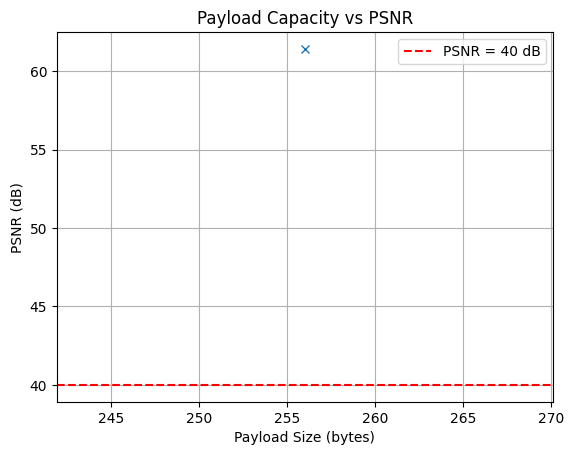

In [4]:
import matplotlib.pyplot as plt

plt.plot(df_payload['payload_bytes'], df_payload['psnr_db'], marker='x')
plt.title('Payload Capacity vs PSNR')
plt.xlabel('Payload Size (bytes)')
plt.ylabel('PSNR (dB)')
plt.axhline(40, color='red', linestyle='--', label='PSNR = 40 dB')
plt.legend()
plt.grid(True)
plt.show()
